In [24]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read and Normalized reference distribution

In [27]:
ref_data = pd.read_csv('reference.hist', sep='\t', header=None, names=['length', 'norm_freq'])
ref_data['norm_freq'] = ref_data['norm_freq'] / ref_data['norm_freq'].sum() 

In [35]:
with gzip.open('query.bed.gz', 'rt') as f:
    query_data = pd.read_csv(f, sep='\t', header=None, usecols=[1, 2], names=['start', 'end'])

## Calculating Fragments

In [41]:
query_data['length'] = query_data['end'] - query_data['start']
query_counts = query_data['length'].value_counts().sort_index()
total_query_fragments = len(query_data) 
print(total_query_fragments)

13835737


## Getting expected counts per fragment length from the reference distribution

In [115]:
target_rep0_size = 4_295_020  
ref_dict = dict(zip(ref_data['length'], ref_data['norm_freq']))
all_lengths = np.arange(1, 701)  
target_counts = np.array([int(ref_dict.get(length, 0) * target_rep0_size) for length in all_lengths])


## Creating Rep 0 by Subsampling Query Data

In [117]:
rep0_lengths = []
length_counts = query_data['length'].value_counts()

## For each fragment length, sample min(target, available)

In [119]:
for length in all_lengths:
    available = length_counts.get(length, 0)
    target = target_counts[length - 1]  # Adjust for zero-based indexing
    count_to_sample = min(target, available)
    if count_to_sample > 0:
        sample = query_data[query_data['length'] == length].sample(n=count_to_sample, random_state=42)
        rep0_lengths.extend(sample['length'].values)
rep0_lengths = np.array(rep0_lengths)
total_rep0 = len(rep0_lengths)

In [153]:
bins = np.arange(1, 702)  
bin_centers = (bins[:-1] + bins[1:]) / 2  
query_hist, _ = np.histogram(query_lengths, bins=bins, density=True)## Computing Normailzed histogram
rep0_hist, _ = np.histogram(rep0_lengths, bins=bins, density=True)

## plot

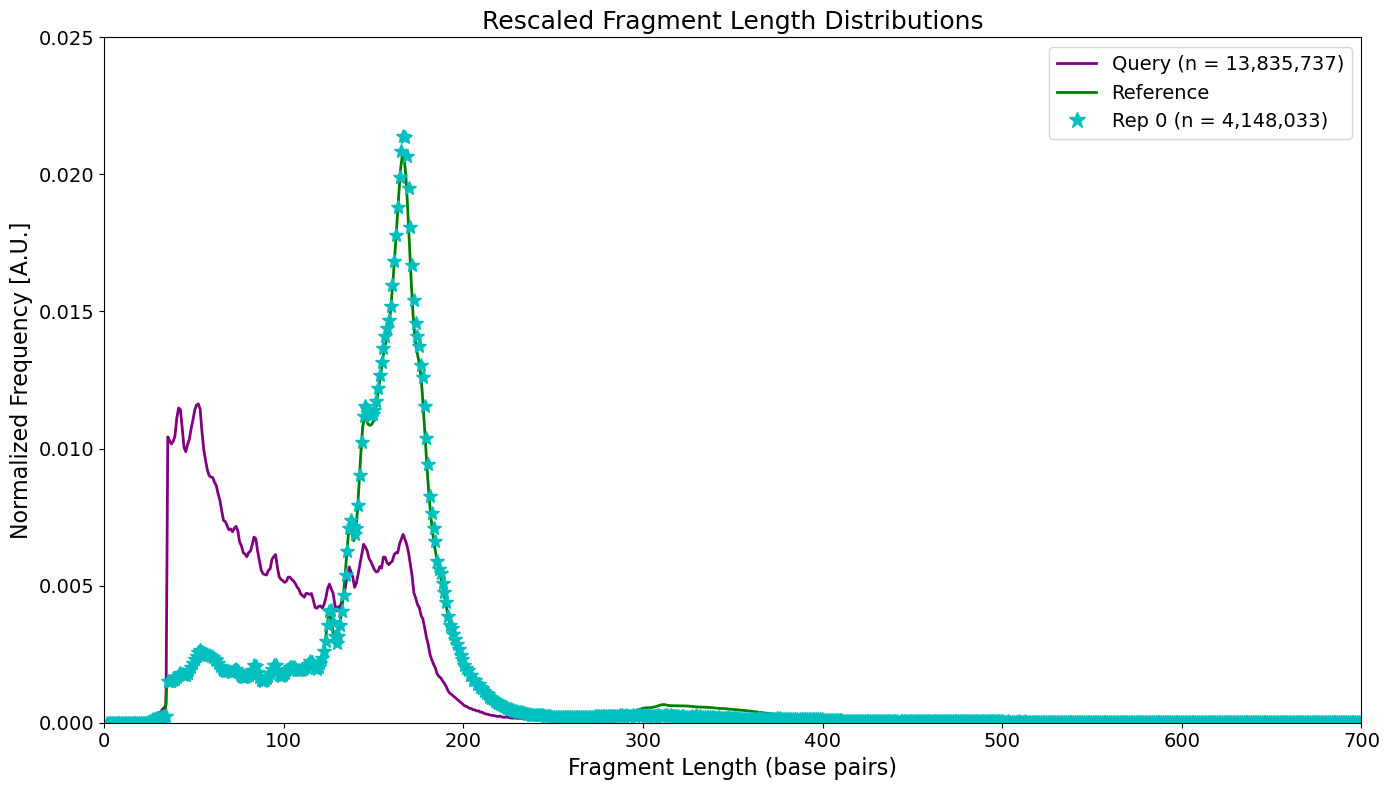

In [167]:
plt.figure(figsize=(14, 8))
plt.plot(bin_centers, query_hist, color='purple', lw=2)
plt.plot(ref_data['length'], ref_data['norm_freq'], 'g-', lw=2) 
plt.plot(bin_centers, rep0_hist, 'c*', markersize=10) 

# Add Custom Legend
legend_elements = [
    Line2D([0], [0], color='purple', lw=2, label=f'Query (n = {total_query:,})'),
    Line2D([0], [0], color='green', lw=2, label='Reference'),
    Line2D([0], [0], marker='*', color='c', linestyle='None', markersize=12, label=f'Rep 0 (n = {total_rep0:,})')
]
plt.legend(handles=legend_elements, fontsize=14)

# Format the Plot
plt.xlabel('Fragment Length (base pairs)', fontsize=16)
plt.ylabel('Normalized Frequency [A.U.]', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 700)
plt.ylim(0, 0.025)
plt.title('Rescaled Fragment Length Distributions', fontsize=18)
plt.tight_layout()
plt.savefig('fragment_length_distribution.png')
plt.show()
plt.close()